# TP 2 Machine Learning - Marcoux Pépin Thomas

In [1]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd

import nltk    #Natural language processing tool-kit
nltk.download('stopwords')
  
from nltk.corpus import stopwords                   #Stopwords corpus

from keras.datasets import imdb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eliasnhiri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


Dans la suite de ce TP on s'intéresse à phrases relatives à des avis de films. Chaque phrase est "labelée" de manière à être associée à un avis positif ou négatif. Notre but sera de determiner si certains mots précis permettent de déterminer le sens d'une phrase mais aussi de prédire si une nouvelle phrase donnée est un avis positif ou négatif.

### Importation des données

In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

In [3]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(25000,) (25000,)
(25000,) (25000,)


On s'intéresse à un jeu de données comportant 25 000 avis.

In [4]:
np.unique(y_train)

array([0, 1])

Comme cité plus haut, chaque phrase est associée à une valeur, 1 pour positif, 0 pour négatif. Nous sommes donc face à un problème logistique.

In [291]:
df1 = pd.DataFrame(X_train)
df2 = pd.DataFrame(y_train)
df = pd.concat([df1, df2],axis=1, join='inner')
df.columns=["sentence", "label"]
df.head()

,sentence,label
0,"[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, ...",1
1,"[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463,...",0
2,"[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5...",0
3,"[1, 4, 18609, 16085, 33, 2804, 4, 2040, 432, 1...",1
4,"[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 1...",0


La particularité de nos données réside dans le fait que chaque mot est associé à un nombre qui lui est propre. On pourra associer à un nombre son mot, et un mot à son nombre via un dictionnaire relatif aux données étudiées.

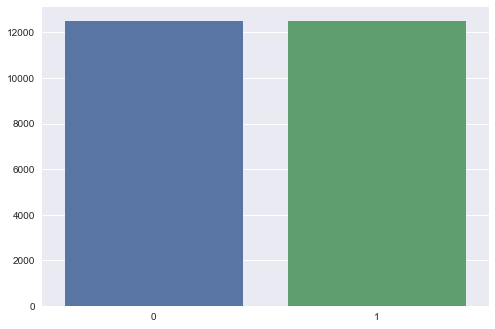

In [231]:
sns.barplot(np.unique(df['label']),df.groupby('label').count().values[:,0])

Notre jeu de donnée comporte autant d'avis négatifs que de positifs, de manière à ne pas faire resortir une tendance trop irrégulière. On remarque également que les avis neutres ne sont pas considérés ici.

## Bag of words 

### Préparation des données

In [234]:
limit = 1000
X= df['sentence']
X_sub= df['sentence'][0:limit]
X_sub.head()

0    [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, ...
1    [1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463,...
2    [1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5...
3    [1, 4, 18609, 16085, 33, 2804, 4, 2040, 432, 1...
4    [1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 1...
Name: sentence, dtype: object

Malheureusement, notre jeu de données étant relativement conséquent, la machine utilisée ne permet pas de correctement étudier la totalité des données. C'est pourquoi on choisit, par soucis de puissance, une sous-partie de nos données de taille 1000. 

### Recherche des mots les plus fréquents

In [236]:
imdb.get_word_index()

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

La commande précédente permet d'afficher le dictionnaire, l'objet qui associe à un mot son nombre, utilisé pour ces données.

In [9]:
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    print(listOfKeys)

La fonction `getKeysByValue` définie ci dessus sera très utile dans la suite puisqu'elle permet, grâce au dictionnaire `dictOfElements`, de donner le mot associé à `valueToFind`.

In [14]:
def changeValueToWords(dictOfElements, X):
    for i in range(X.shape[0]):
        listOfItems = dictOfElements.items()
        listOfKeys = list()
        for valueToFind in X[i]:
            for item  in listOfItems:
                if item[1] == valueToFind:
                    listOfKeys.append(item[0])
            X[i] = listOfKeys

La fonction définie ci dessus permet d'appliquer à chaque mot de chaque phrase de X, la fonction `getKeysByValue`.

In [15]:
dictOfElements = imdb.get_word_index()
changeValueToWords(dictOfElements, X_sub)
X_sub.head()

0      [the, as, you, with, out, themselves, powerful...
1      [the, thought, solid, thought, senator, do, ma...
2      [the, as, there, in, at, by, br, of, sure, man...
3      [the, of, bernadette, mon, they, halfway, of, ...
4      [the, sure, themes, br, only, acting, i, i, wa...
5      [the, effort, still, been, that, usually, make...
6      [the, boiled, full, involving, to, impressive,...
7      [the, of, installed, local, of, their, br, of,...
8      [the, out, can't, some, to, hit, looking, when...
9      [the, as, on, there, plot, she's, iii, film, t...
10     [the, clear, fact, entertaining, there, life, ...
11     [the, no, was, personality, as, on, was, me, t...
12     [the, was, did, hands, fact, absolute, was, th...
13     [the, especially, like, after, same, scientist...
14     [the, child, on, they, where, totally, instead...
15     [the, is, rate, hope, br, my, out, double, thi...
16     [the, auto, cross, this, of, mental, it, of, d...
17     [the, they, of, rukh, br

Après application de `function`, chaque nombre est devenu un mot. Il reste encore à reconstituer des phrases :

In [237]:
for i in range(limit):
    X_sub[i] = ' '.join(X_sub[i])
X_sub.head()

0    the as you with out themselves powerful lets l...
1    the thought solid thought senator do making to...
2    the as there in at by br of sure many br of pr...
3    the of bernadette mon they halfway of identity...
4    the sure themes br only acting i i was favouri...
Name: sentence, dtype: object

##### Création du dictionnaire relatif à X_sub

In [240]:
count_vect = CountVectorizer()
X_sub_counts = count_vect.fit_transform(X_sub)
dictionary_sub   = count_vect.get_feature_names()

In [242]:
def most_frequent_words(count_vect,data):    
    data_counts = count_vect.fit_transform(data)
    dictionary   = count_vect.get_feature_names()
    print("Taille du dictionnaire : ",len(dictionary))
    word_counts = pd.DataFrame(data_counts.toarray(),columns = dictionary)
    word_total_counts = pd.DataFrame()
    word_total_counts['count'] = word_counts.sum(axis=0)
    word_total_counts['word'] = dictionary
    word_total_counts_sorted_top  = word_total_counts.sort_values(by="count",ascending = False).iloc[0:20]
    plt.figure(figsize=(15,8))
    sns.barplot(x = word_total_counts_sorted_top.index,y=word_total_counts_sorted_top['count'])
    plt.xticks(rotation=90,fontsize=10)
    plt.show()
    return {'data_counts' : data_counts, 'word_total_counts' :word_total_counts, 'dictionary' : dictionary}

La fonction `most_frequent_words` permet de compter l'apparation de chaque mot dans le `data` considéré et d'en faire une représentation graphique.

Taille du dictionnaire :  18478


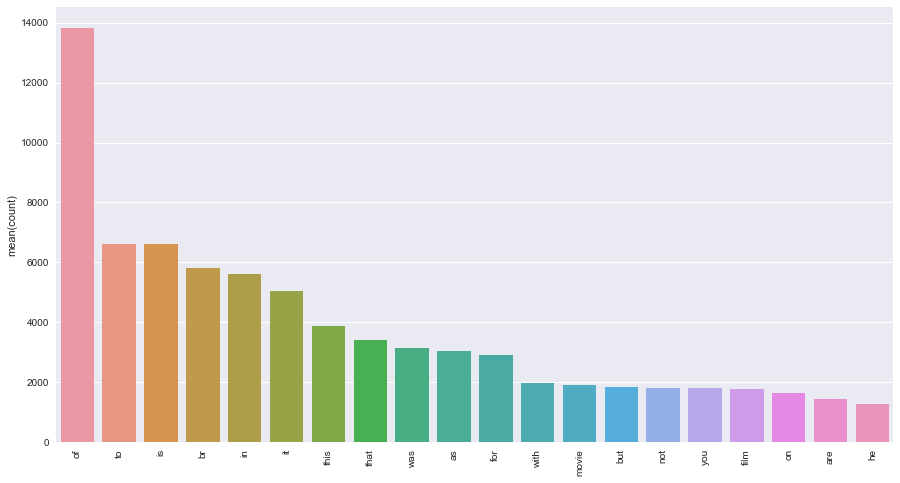

In [256]:
most_frequent_words_sub = most_frequent_words(count_vect,X_sub)

Parmis les 18 478 mots utilisés dans les 1000 premières phrases, les mots les plus présents dans nos phrases sont des prépositions. Or elles n'apportent aucune information sur la positivité ou négativité des avis relevés. On choisit donc de s'en séparer.

In [244]:
stop = set(stopwords.words('english'))

Taille du dictionnaire :  18337


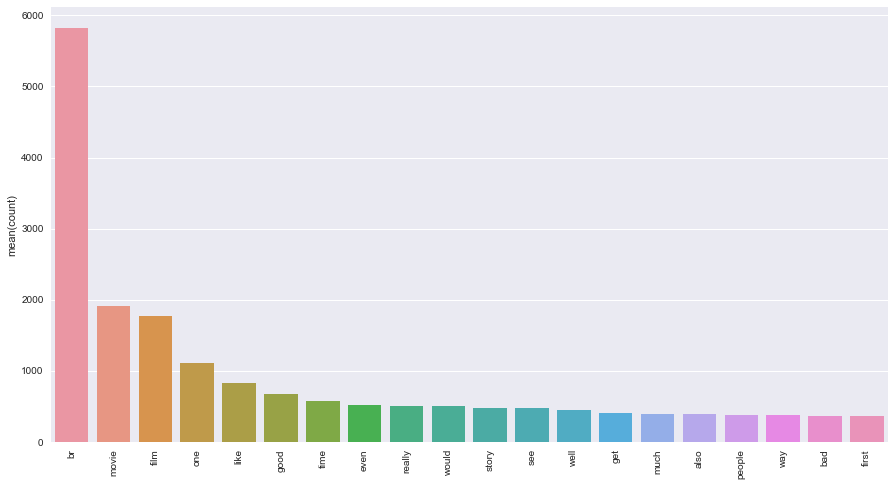

In [245]:
count_vect_sw = CountVectorizer(stop_words=stop)
most_frequent_words_sw = most_frequent_words(count_vect_sw,X_sub)

Nous nous sommes séparés de 141 mots, cependant certains mots restants n'apportent pas non plus d'informations sur les avis. Mettons à jour notre liste de `stopwords`.

In [277]:
stop.update({'br','film','films','time','even','story','see','one','movie','movies'})

Taille du dictionnaire :  18324


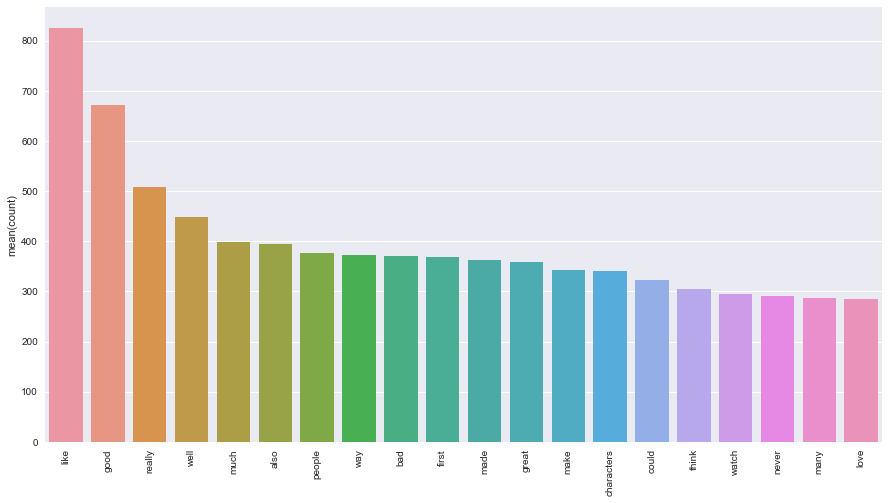

In [278]:
count_vect_sw = CountVectorizer(stop_words=stop)
most_frequent_words_sw = most_frequent_words(count_vect_sw,X_sub)

## Visualisation du corpus

In [279]:
Y_sub = df['label'][0:limit]
Y_sub['labels'] = np.array([i for i in Y_sub[0:limit]])

### Méthode de comptage

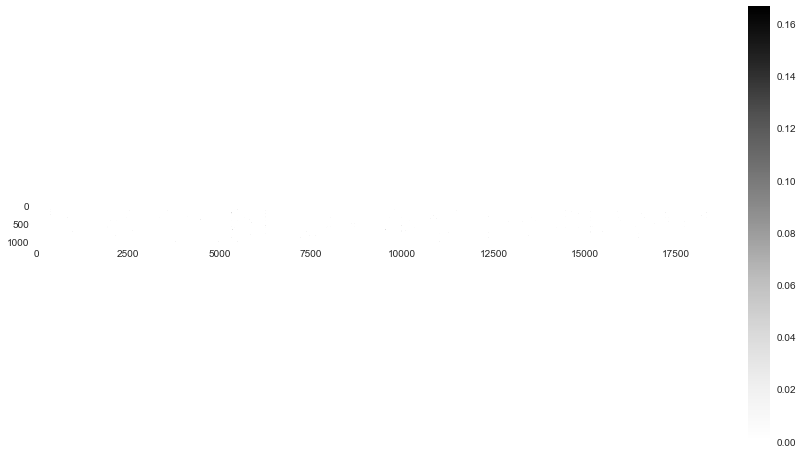

In [280]:
most_frequent = np.array(most_frequent_words_sw['data_counts'].toarray())
hist = most_frequent / most_frequent.sum(axis=1)[:,None]
plt.figure(figsize=(15,8))
plt.imshow(hist[np.argsort(Y_sub['labels']),:],)
plt.colorbar()

La figure précédente permet de visualiser la "poids" de chaque mot dans la ou les phrases ou il apparaît. Par poids on comprends sa connotation à être un bon plutôt positif ou plutôt négatif.

On représente le poids des 18 325 mots dans chaque phrase, plus le point représenté est foncé, plus son poids est important. Évidemment, beaucoup de points apparaissent blancs, chaque mot n'étant pas présent dans toutes les phrases.

### Méthode TF_IDF

In [281]:
transformer = TfidfTransformer(smooth_idf=False)
tf_idf_transf = transformer.fit_transform(most_frequent_words_sw['data_counts'])

On applique la méthode de TF-IDF à nos données afin de normaliser les poids de nos données et, a fortiori, d'obtenir une prédiction plus appropriée de nos labels.

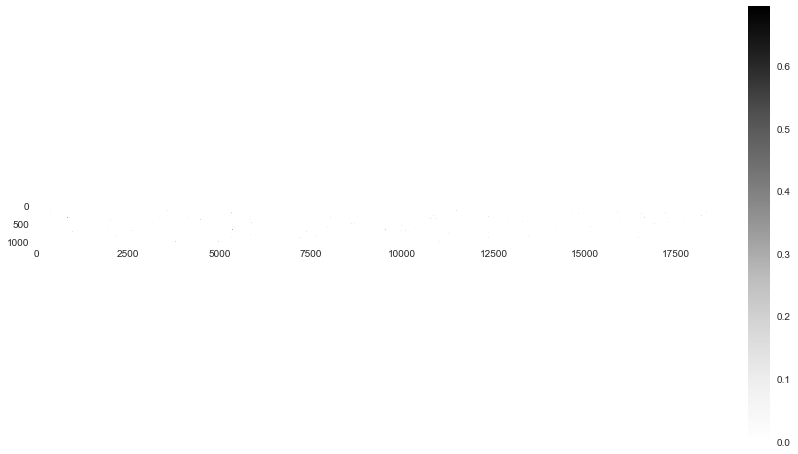

In [282]:
plt.figure(figsize=(15,8))
plt.imshow(tf_idf_transf.toarray()[np.argsort(Y_sub['labels']),:])
plt.colorbar()

On remarque les points désormais présents sont légérement différents de ceux du graphe précédent.

## Apprentissage supervisé

### Classification par Naïve Bayes

In [283]:
NB_counts = MultinomialNB()
NB_counts.fit(X=most_frequent_words_sw['data_counts'],y=Y_sub['labels'])
accuracy_score(NB_counts.predict(most_frequent_words_sw['data_counts']),Y_sub['labels'])

0.98399999999999999

En appliquant cette méthode de classification par Naïve Bayes, on obtient un score de précision de plus de 98%. Le score obtenu est très bon mais sachant que l'on étudie ici qu'un faible pourcentage des données à notre disposition, ce score n'est malheureusement pas du tout représentatif du jeu global.

### Classification par TF-IDF

In [284]:
NB_tfidf = GaussianNB()
NB_tfidf.fit(X=tf_idf_transf.toarray(),y=Y_sub['labels'])
accuracy_score(NB_tfidf.predict(tf_idf_transf.toarray()),Y_sub['labels'])

0.996

En appliquant la méthode TF-IDF on obtient un score encore meilleur, on peut conclure que cette méthode est plus adaptée a la prédiction de nos labels. Mais l'on se doit aussi d'appliquer le raisonnement précédent quant à la légitimité de ce résultat.

#### Comparaison de méthodes

In [285]:
Y_sub['prediction_counts'] = NB_counts.predict(most_frequent_words_sw['data_counts'])
Y_sub['prediction_tfidf'] = NB_tfidf.predict(tf_idf_transf.toarray())
Y_sub[Y_sub['prediction_tfidf'] != Y_sub['labels']]

97     1
653    1
732    1
768    1
Name: label, dtype: object

In [286]:
Y_sub[Y_sub['prediction_counts'] != Y_sub['labels']]

97     1
163    1
221    1
256    1
307    1
339    1
421    1
461    1
463    1
469    1
491    1
537    1
589    1
626    1
810    0
953    1
Name: label, dtype: object

Les commandes précédentes permettent de visualiser sur quelles phrases chaque méthode commet ses erreurs de prédiction. On remarque que, sauf pour la phrase numéro 97, les méthodes ne font pas des erreurs d'analyse sur les mêmes phrases.

### Classification par SGDClassifier

In [287]:
NB_logistic = SGDClassifier(loss='hinge', penalty='l2',\
                           alpha=1e-3, random_state=42)   # arg optionnel : ",\max_iter=5, tol=None"
logistic_fit = NB_logistic.fit(X=tf_idf_transf.toarray(),y=Y_sub['labels'])
accuracy_score(NB_logistic.predict(tf_idf_transf.toarray()),Y_sub['labels'])

0.997

La méthode de classification SGD permet d'obtenir un score de précision encore meilleur qu'avec TF-IDF.

### Mots aux plus forts poids

In [289]:
print("Mot au coefficient le plus négatif : ", most_frequent_words_sw['dictionary'][np.argsort(NB_logistic.coef_)[0][0]])
print("Mot au coefficient le plus positif : ", most_frequent_words_sw['dictionary'][np.argsort(NB_logistic.coef_)[0][-1]])

Mot au coefficient le plus négatif :  sure
Mot au coefficient le plus positif :  played


D'après la dernière méthode utilisée, les mots ayant les plus fort coefficients sont 'sure' et 'played'. Or ces mots n'ont aucune connation positive ou négative. On aurait souhaité, par exemple, 'good' pour le mot le plus positif et 'bad' pour le mot le plus négatif.

Pour obtenir le résultat souhaité il faudrait considérer un jeu de donnée plus conséquent, sur une machine plus puissante. Ou bien affiner notre liste des stopwords au risque d'enlever des mots importants dans un contexte précis.

### Méthode Pipeline

In [225]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2',\
                           alpha=1e-3, random_state=42)),])

In [226]:
text_clf.fit(X_sub, Y_sub['labels'])
accuracy_score(text_clf.predict(X_sub),Y_sub['labels'])

0.99399999999999999

On obtient un meilleur score que pour les deux premières méthodes utilisées. Mais l'on est pas sur de pouvoir tirer la même conclusion si l'on considère l'ensemble du jeu de données.